<a href="https://colab.research.google.com/github/KashfiRashid/A2_hybrid_scifi_generator/blob/main/hybrid_scifi_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IAT460 A2: Hybrid Sci-Fi Generator
### Generative Grammar + Markov Chain → L-System Visuals

## How to Run
1. Open this notebook in Google Colab
2. Run all cells from top to bottom
3. Re-run Sample Output cells to generate different stories and visuals
4. Use the Interactive Mode cell at the bottom to choose mood, grammar, and chain

## What to Adjust
- `mood` in sample outputs: `'dread'`, `'wonder'`, `'tension'`, or `None`
- `markov_words` controls length of field notes
- `temperature` in `generate_markov()` (lower = more coherent, higher = more surprising)
- L-System `iterations`, `angle`, `distance` in rulesets for visual variation

## Requirements
This notebook uses only Python standard library + matplotlib:
- `random`, `math`, `collections`
- `matplotlib`

In [1]:
# --- Imports ---
import random
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict, Counter

## Generative Grammar Engine

In [2]:
# --- Generative Grammar Core ---

def generate(symbol, grammar):
    """Recursively expand a symbol using grammar rules."""
    if symbol in grammar:
        production = random.choice(grammar[symbol])
        if isinstance(production, list):
            return ' '.join(generate(s, grammar) for s in production)
        return production
    return symbol

def generate_weighted(symbol, grammar):
    """Expand symbols with optional weighted productions."""
    if symbol in grammar:
        productions = grammar[symbol]
        # Check if weighted (list of tuples)
        if isinstance(productions[0], tuple):
            choices, weights = zip(*productions)
            production = random.choices(choices, weights=weights)[0]
        else:
            production = random.choice(productions)
        if isinstance(production, list):
            return ' '.join(generate_weighted(s, grammar) for s in production)
        return production
    return symbol

## Sci-Fi Grammar Rulesets

In [3]:
# --- Ruleset 1: Mission Log Generator ---
mission_grammar = {
    'S': [
        (['OPENING', 'ENCOUNTER', 'STATUS'], 0.5),
        (['OPENING', 'DISCOVERY', 'STATUS'], 0.3),
        (['OPENING', 'ENCOUNTER', 'DISCOVERY', 'STATUS'], 0.2)
    ],
    'OPENING': [
        ['RANK', 'NAME', 'LOG_INTRO', 'LOCATION'],
    ],
    'RANK': ['Captain', 'Commander', 'Lieutenant', 'Dr.', 'Officer'],
    'NAME': ['Voss', 'Okafor', 'Tanaka', 'Reyes', 'Ashworth', 'Kaine'],
    'LOG_INTRO': [
        'reporting from orbit above',
        'recording from the surface of',
        'transmitting from deep within',
        'logging final approach to'
    ],
    'LOCATION': [
        ['PLANET_NAME', '—', 'PLANET_DESC'],
    ],
    'PLANET_NAME': ['Erythros-7', 'Vantablack Hollow', 'Nyx-12', 'Cygnus Reach', 'Lithara Prime', 'Oberon Deep'],
    'PLANET_DESC': [
        'a world of frozen methane seas.',
        'a barren moon scarred by ancient impact craters.',
        'a dense jungle planet pulsing with bioluminescence.',
        'a gas giant ringed by crystalline debris.',
        'a rogue planet drifting between star systems.',
        'a tidally locked world split between fire and ice.'
    ],

    'ENCOUNTER': [
        ['SENSOR', 'ENTITY', 'BEHAVIOR'],
    ],
    'SENSOR': [
        'Sensors detected', 'Long-range scans revealed', 'The probe returned data on',
        'Thermal imaging picked up', 'We made visual contact with'
    ],
    'ENTITY': [
        'a silicon-based organism', 'a swarm of luminous spores',
        'a massive crystalline structure', 'an abandoned orbital station',
        'a colony of burrowing automata', 'a shifting geometric anomaly'
    ],
    'BEHAVIOR': [
        'broadcasting on a dead frequency.',
        'expanding at an accelerating rate.',
        'reacting to our presence with hostility.',
        'emitting patterns that resemble language.',
        'slowly migrating toward the planet core.',
        'phasing in and out of visible light.'
    ],

    'DISCOVERY': [
        ['FIND_INTRO', 'ARTIFACT', 'ARTIFACT_DETAIL'],
    ],
    'FIND_INTRO': [
        'Ground team recovered', 'Hidden beneath the surface we found',
        'Among the ruins lay', 'Analysis confirmed the presence of'
    ],
    'ARTIFACT': [
        'a shard of unknown alloy', 'a device emitting zero-point radiation',
        'organic circuitry fused with stone', 'a map etched in neutron star isotopes',
        'a dormant AI core', 'fossilized technology predating known civilizations'
    ],
    'ARTIFACT_DETAIL': [
        '— its origin predates this star system.',
        '— initial scans are inconclusive.',
        '— it responded to human bioelectric fields.',
        '— we are proceeding with extreme caution.',
        '— recommend quarantine protocols immediately.',
        '— further study could change everything we know.'
    ],

    'STATUS': [
        'Crew morale is steady. Awaiting further orders.',
        'Power reserves critical. Requesting immediate extraction.',
        'No casualties yet. Proceeding to secondary objective.',
        'Mission parameters have changed. We are not alone here.',
        'Comm relay damaged. This may be our last transmission.',
        'All systems nominal. But something feels wrong.'
    ]
}

# --- Ruleset 2: Planet Description Generator ---
planet_grammar = {
    'S': [['SKY', 'TERRAIN', 'FLORA', 'ATMOSPHERE']],
    'SKY': [
        'Twin suns bled orange across the horizon.',
        'The sky was a bruise of violet and black.',
        'A pale ring of ice crystals arced overhead.',
        'No stars were visible — only the glow of distant nebulae.',
        'Three moons hung low, casting overlapping shadows.',
        'The aurora above pulsed in rhythms like breathing.'
    ],
    'TERRAIN': [
        'The ground was glass — smooth, reflective, endless.',
        'Jagged spires of obsidian rose from cracked earth.',
        'Rolling dunes of metallic sand stretched to the horizon.',
        'The surface was soft and fibrous, like walking on living tissue.',
        'Frozen rivers carved deep canyons through basalt plains.',
        'Columns of hexagonal stone formed a natural cathedral.'
    ],
    'FLORA': [
        ['FLORA_DESC'],
    ],
    'FLORA_DESC': [
        'Towering fronds of translucent coral swayed without wind.',
        'Clusters of bioluminescent fungi pulsed in slow waves.',
        'Spiral trees with mirrored bark reflected the sky.',
        'Black vines crept across every surface, humming faintly.',
        'Fields of crystal flowers chimed as temperature shifted.',
        'No vegetation. Only silence and dust.'
    ],
    'ATMOSPHERE': [
        'The air tasted of copper and ozone.',
        'Breathing was shallow — the atmosphere thin but survivable.',
        'Every exhale formed tiny ice crystals that floated upward.',
        'A faint hum vibrated through the air, just below hearing.',
        'The wind carried a scent like burnt sugar and iron.',
        'Gravity felt lighter here. Each step was a small leap.'
    ]
}

## Markov Chain Engine

In [4]:
# --- Markov Chain Core ---

def build_markov_chain(text, order=2):
    """Build a word-level Markov chain from training text."""
    chain = defaultdict(list)
    words = text.split()
    for i in range(len(words) - order):
        state = tuple(words[i:i + order])
        next_word = words[i + order]
        chain[state].append(next_word)
    return chain

def generate_markov(chain, num_words=50, temperature=1.0):
    """Generate text from a Markov chain with temperature control."""
    words = list(random.choice(list(chain.keys())))
    order = len(words)
    for _ in range(num_words - order):
        state = tuple(words[-order:])
        if state not in chain:
            break
        candidates = chain[state]
        # Apply temperature
        counts = defaultdict(int)
        for w in candidates:
            counts[w] += 1
        weights = [c ** (1.0 / temperature) for c in counts.values()]
        total = sum(weights)
        weights = [w / total for w in weights]
        next_word = random.choices(list(counts.keys()), weights=weights)[0]
        words.append(next_word)
    return ' '.join(words)

def analyze_chain(chain):
    """Print statistics about a Markov chain."""
    num_states = len(chain)
    total_transitions = sum(len(v) for v in chain.values())
    avg = total_transitions / num_states if num_states > 0 else 0
    print(f"Unique states: {num_states}")
    print(f"Total transitions: {total_transitions}")
    print(f"Avg transitions per state: {avg:.2f}")

def print_transition_table(chain, max_states=8):
    """Display a sample of the transition table."""
    print("\nState -> Possible Next Words")
    for i, (state, nexts) in enumerate(chain.items()):
        if i >= max_states:
            break
        print(f"  {state} -> {dict(Counter(nexts))}")

## Sci-Fi Training Corpus + Chain Building

In [5]:
# --- Training Text 1: Deep Space Exploration Log ---
space_log = '''
The ship drifted through the silence between stars where nothing moved and nothing breathed.
Instruments hummed in the dark as the crew slept in frozen suspension. The hull groaned under
the weight of empty space pressing in from all sides. Captain Voss stared at the viewport and
saw only the cold light of distant suns reflected on the hull. There was no comfort in the
stars anymore. Every system check returned the same readings and every corridor echoed with
the absence of life. The engine core pulsed with a rhythm like a slow heartbeat fading.
Warning lights flickered across the bridge casting red shadows on the walls. The ship was old
and the void was patient. Somewhere ahead a signal repeated on a frequency no one recognized.
It came from a place that should not exist on any chart. The crew woke to alarms and static
and the taste of recycled air. Voss ordered a course change toward the signal knowing it
could be salvation or something far worse. The ship turned slowly and the stars shifted in the
viewport like the universe rearranging itself around them.
'''

# --- Training Text 2: Alien World Survey ---
alien_world = '''
The surface stretched out in every direction like a wound exposed to starlight. Crystalline
formations rose from the ground catching light and splitting it into colors that had no name.
The soil was warm to the touch and pulsed faintly beneath our boots. We walked through fields
of glass flowers that chimed when the wind shifted direction. The air was thick with particles
that glowed like fireflies suspended in amber. Nothing here followed the rules we knew. Trees
grew downward into the sky their roots clawing at the clouds above. Rivers of liquid metal
carved slow paths through valleys of singing stone. The survey team moved in silence because
words felt wrong in this place. Every sound we made was absorbed and returned as something
different. A whisper became a chord. A footstep became a drum. The planet was listening to us
and we could feel it thinking. Dr. Tanaka knelt beside a formation and her instruments
flickered and died. She said the readings made no sense. The crystal was alive and it was
older than the star it orbited. We collected samples but none of us believed they would
survive the journey home. This world did not want to be understood. It wanted to be
experienced.
'''

# Build both chains
space_chain = build_markov_chain(space_log, order=2)
alien_chain = build_markov_chain(alien_world, order=2)

print("Space Log chain:")
analyze_chain(space_chain)
print_transition_table(space_chain)

print("\n\nAlien World chain:")
analyze_chain(alien_chain)
print_transition_table(alien_chain)

Space Log chain:
Unique states: 176
Total transitions: 185
Avg transitions per state: 1.05

State -> Possible Next Words
  ('The', 'ship') -> {'drifted': 1, 'was': 1, 'turned': 1}
  ('ship', 'drifted') -> {'through': 1}
  ('drifted', 'through') -> {'the': 1}
  ('through', 'the') -> {'silence': 1}
  ('the', 'silence') -> {'between': 1}
  ('silence', 'between') -> {'stars': 1}
  ('between', 'stars') -> {'where': 1}
  ('stars', 'where') -> {'nothing': 1}


Alien World chain:
Unique states: 203
Total transitions: 205
Avg transitions per state: 1.01

State -> Possible Next Words
  ('The', 'surface') -> {'stretched': 1}
  ('surface', 'stretched') -> {'out': 1}
  ('stretched', 'out') -> {'in': 1}
  ('out', 'in') -> {'every': 1}
  ('in', 'every') -> {'direction': 1}
  ('every', 'direction') -> {'like': 1}
  ('direction', 'like') -> {'a': 1}
  ('like', 'a') -> {'wound': 1}


## Hybrid Text Generator

In [6]:
# --- Hybrid Generator: Grammar Structure + Markov Texture ---

def hybrid_generate(grammar, chain, markov_words=40, temperature=0.8):
    """
    Generate text using grammar for structure and Markov for descriptive passages.
    The grammar builds the skeleton, the Markov chain adds atmospheric texture.
    """
    # Grammar generates the structured narrative
    if isinstance(grammar['S'][0], tuple):
        structure = generate_weighted('S', grammar)
    else:
        structure = generate('S', grammar)

    # Markov generates a descriptive passage
    texture = generate_markov(chain, num_words=markov_words, temperature=temperature)

    return structure, texture

def format_hybrid_output(title, structure, texture):
    """Format the combined output nicely."""
    print(f"{'='*60}")
    print(f"  {title}")
    print(f"{'='*60}")
    print()
    print("[MISSION LOG]")
    print(structure)
    print()
    print("[FIELD NOTES]")
    print(texture)
    print()
    print(f"{'='*60}")

# --- Mood system for Markov generation ---
MOOD_WORDS = {
    'dread': {'dark', 'silence', 'nothing', 'void', 'dead', 'cold', 'shadow', 'warning', 'fading', 'absence'},
    'wonder': {'light', 'glow', 'crystal', 'colors', 'alive', 'singing', 'chimed', 'stars', 'beautiful', 'shimmer'},
    'tension': {'signal', 'alarms', 'static', 'flickered', 'wrong', 'worse', 'unknown', 'shifted', 'pressing', 'groaned'}
}

def generate_markov_with_mood(chain, mood=None, num_words=40):
    """Markov generation with mood biasing."""
    words = list(random.choice(list(chain.keys())))
    order = len(words)
    for _ in range(num_words - order):
        state = tuple(words[-order:])
        if state not in chain:
            break
        candidates = chain[state]
        if mood and mood in MOOD_WORDS:
            biased = []
            for w in candidates:
                if w.lower().strip('.,;:!') in MOOD_WORDS[mood]:
                    biased.extend([w] * 3)
                else:
                    biased.append(w)
            next_word = random.choice(biased)
        else:
            next_word = random.choice(candidates)
        words.append(next_word)
    return ' '.join(words)

# Quick test
structure, texture = hybrid_generate(mission_grammar, space_chain)
format_hybrid_output("TEST TRANSMISSION", structure, texture)

  TEST TRANSMISSION

[MISSION LOG]
Captain Reyes recording from the surface of Nyx-12 — a gas giant ringed by crystalline debris. We made visual contact with a shifting geometric anomaly broadcasting on a dead frequency. No casualties yet. Proceeding to secondary objective.

[FIELD NOTES]
a place that should not exist on any chart. The crew woke to alarms and static and the stars shifted in the stars anymore. Every system check returned the same readings and every corridor echoed with the absence of life.



## L-System Engine

In [7]:
# --- L-System Core ---

def create_l_system(axiom, rules, iterations):
    """Generate L-System string by applying rules iteratively."""
    result = axiom
    for _ in range(iterations):
        new_string = ""
        for char in result:
            new_string += rules.get(char, char)
        result = new_string
    return result

def draw_l_system(instructions, angle, distance, start_pos=(0, 0), start_angle=90,
                  color_map=None, thickness_map=None, ax=None):
    """
    Draw L-System using matplotlib.

    color_map: dict mapping depth to color
    thickness_map: dict mapping depth to line width
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    x, y = start_pos
    current_angle = start_angle
    stack = []
    depth = 0

    # Default colors: shift from cyan to magenta as depth increases
    default_colors = ['#00ffcc', '#00ccff', '#6699ff', '#9966ff', '#cc33ff', '#ff00cc']

    for cmd in instructions:
        if cmd == 'F' or cmd == 'G':
            # Calculate new position
            rad = math.radians(current_angle)
            new_x = x + distance * math.cos(rad)
            new_y = y + distance * math.sin(rad)

            # Get color and thickness for current depth
            if color_map and depth in color_map:
                color = color_map[depth]
            else:
                color = default_colors[depth % len(default_colors)]

            if thickness_map and depth in thickness_map:
                lw = thickness_map[depth]
            else:
                lw = max(0.5, 3.0 - depth * 0.4)

            ax.plot([x, new_x], [y, new_y], color=color, linewidth=lw, solid_capstyle='round')
            x, y = new_x, new_y

        elif cmd == '+':
            current_angle += angle
        elif cmd == '-':
            current_angle -= angle
        elif cmd == '[':
            stack.append((x, y, current_angle, depth))
            depth += 1
        elif cmd == ']':
            x, y, current_angle, depth = stack.pop()

    ax.set_aspect('equal')
    ax.axis('off')
    return ax

## Alien Flora & Crystal L-System Rulesets

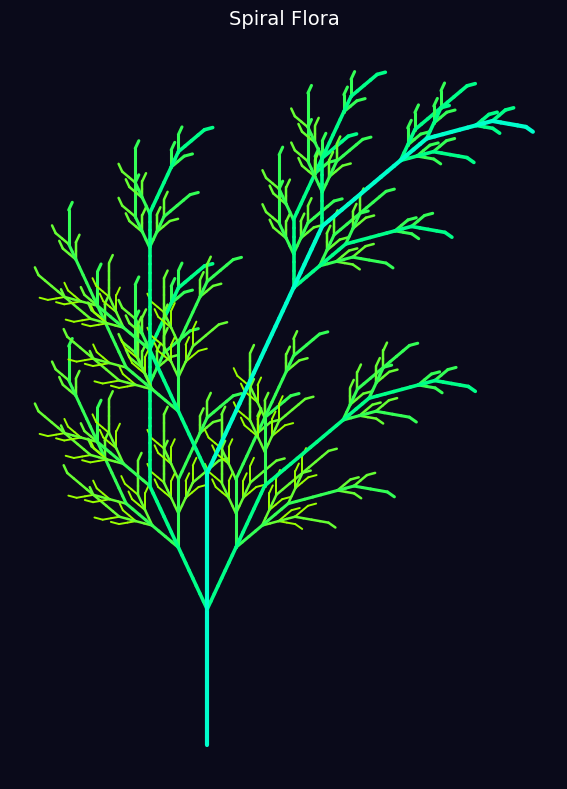

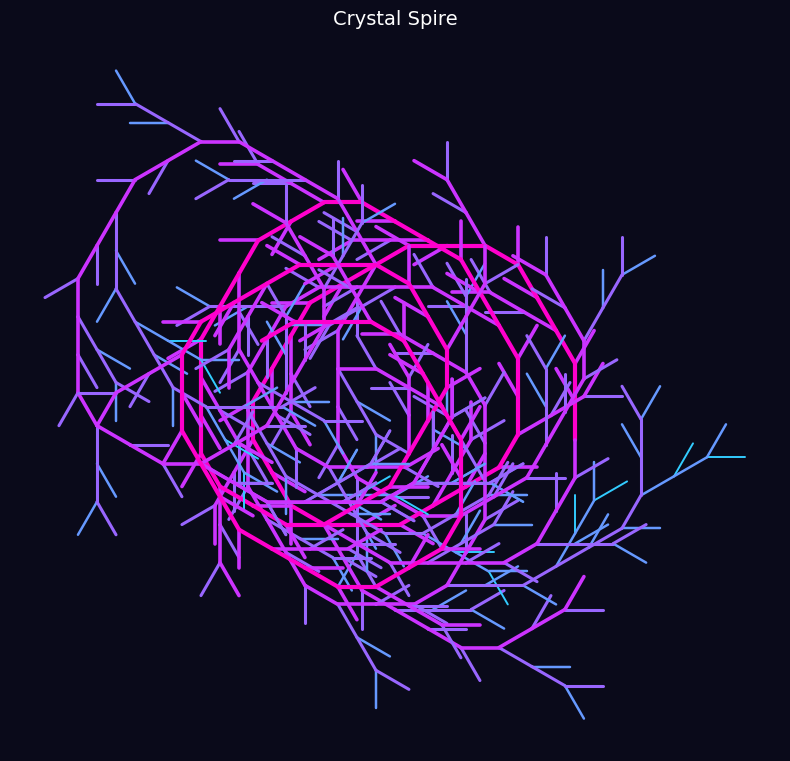

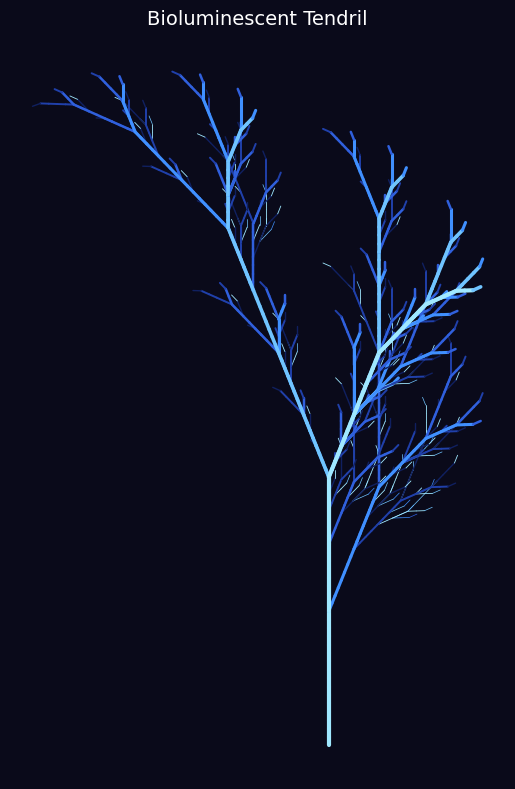

In [8]:
# --- L-System Ruleset 1: Alien Spiral Flora ---
spiral_flora = {
    'axiom': 'X',
    'rules': {
        'X': 'F[+X][-X]F[+X]-FX',
        'F': 'FF'
    },
    'angle': 25,
    'iterations': 5,
    'distance': 3,
    'name': 'Spiral Flora'
}

# --- L-System Ruleset 2: Crystal Spire Formation ---
crystal_spire = {
    'axiom': 'F',
    'rules': {
        'F': 'F[+F]F[-F]+F'
    },
    'angle': 30,
    'iterations': 4,
    'distance': 5,
    'name': 'Crystal Spire'
}

# --- L-System Ruleset 3: Bioluminescent Tendril ---
bio_tendril = {
    'axiom': 'X',
    'rules': {
        'X': 'F-[[X]+X]+F[+FX]-X',
        'F': 'FF'
    },
    'angle': 22,
    'iterations': 5,
    'distance': 3,
    'name': 'Bioluminescent Tendril'
}

# --- Color palettes for each biome ---
PALETTES = {
    'frozen': ['#a0e8ff', '#70c4ff', '#4090ff', '#3060dd', '#2040aa', '#102060'],
    'bioluminescent': ['#00ffcc', '#00ff88', '#33ff55', '#66ff33', '#99ff00', '#ccff00'],
    'crystal': ['#ff00cc', '#cc33ff', '#9966ff', '#6699ff', '#33ccff', '#00ffee'],
    'volcanic': ['#ff3300', '#ff6600', '#ff9900', '#ffcc00', '#ffee00', '#ffff66'],
}

def draw_alien_flora(ruleset, palette_name='bioluminescent', bg_color='#0a0a1a'):
    """Draw an L-System with a sci-fi color palette on dark background."""
    instructions = create_l_system(
        ruleset['axiom'],
        ruleset['rules'],
        ruleset['iterations']
    )

    palette = PALETTES.get(palette_name, PALETTES['bioluminescent'])
    color_map = {i: palette[i % len(palette)] for i in range(10)}

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    fig.patch.set_facecolor(bg_color)
    ax.set_facecolor(bg_color)

    draw_l_system(
        instructions,
        ruleset['angle'],
        ruleset['distance'],
        start_angle=90,
        color_map=color_map,
        ax=ax
    )

    ax.set_title(ruleset['name'], color='white', fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()

# Test each ruleset
draw_alien_flora(spiral_flora, 'bioluminescent')
draw_alien_flora(crystal_spire, 'crystal')
draw_alien_flora(bio_tendril, 'frozen')

## The Connector: Text Drives Visuals

## The Connector: Text Drives Visuals
The biome detection system scans the combined grammar and Markov output for keywords (e.g. "frozen", "crystalline", "jungle") and selects a matching L-System ruleset and color palette. This is the core hybrid mechanic — the text content directly determines the visual output, so every generation produces a thematically coherent pairing of narrative and image.

  TRANSMISSION 001
  Detected Biome: VOLCANIC

[MISSION LOG]
Dr. Okafor logging final approach to Erythros-7 — a barren moon scarred by ancient impact craters. Sensors detected a silicon-based organism slowly migrating toward the planet core. Power reserves critical. Requesting immediate extraction.

[FIELD NOTES]
that glowed like fireflies suspended in amber. Nothing here followed the rules we knew. Trees grew downward into the sky their roots clawing at the clouds above. Rivers of liquid metal carved slow paths through valleys of singing stone. The



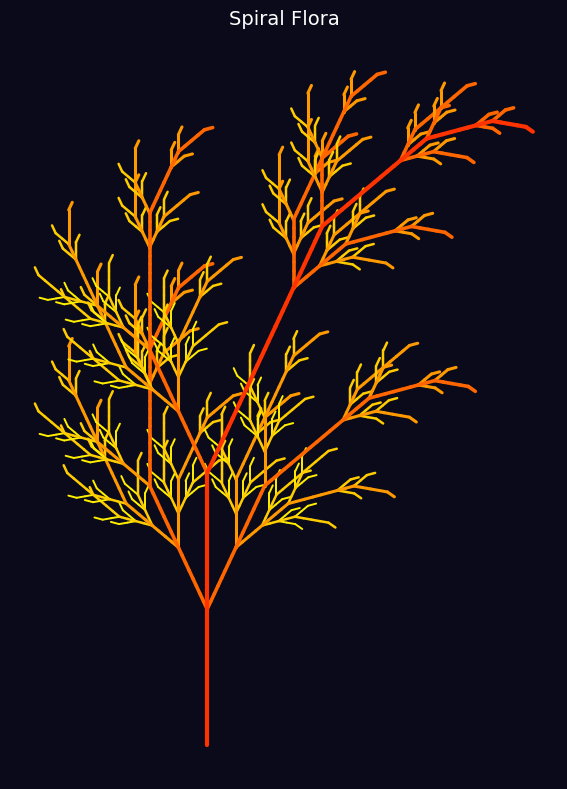

In [9]:
# --- Keyword-to-Visual Mapping ---
# The grammar output determines which L-System and palette to use

BIOME_MAP = {
    'frozen': {
        'keywords': ['frozen', 'ice', 'cold', 'methane', 'crystal'],
        'ruleset': bio_tendril,
        'palette': 'frozen'
    },
    'bioluminescent': {
        'keywords': ['jungle', 'bioluminescence', 'pulsing', 'living', 'flora', 'fungi'],
        'ruleset': spiral_flora,
        'palette': 'bioluminescent'
    },
    'crystal': {
        'keywords': ['crystalline', 'debris', 'glass', 'rogue', 'geometric', 'alloy'],
        'ruleset': crystal_spire,
        'palette': 'crystal'
    },
    'volcanic': {
        'keywords': ['fire', 'locked', 'scarred', 'impact', 'barren', 'cracked'],
        'ruleset': spiral_flora,
        'palette': 'volcanic'
    }
}

def detect_biome(text):
    """Scan generated text for keywords and return the matching biome."""
    text_lower = text.lower()
    scores = {}
    for biome, config in BIOME_MAP.items():
        score = sum(1 for kw in config['keywords'] if kw in text_lower)
        scores[biome] = score

    best = max(scores, key=scores.get)
    # If no keywords matched, pick random
    if scores[best] == 0:
        best = random.choice(list(BIOME_MAP.keys()))
    return best

def generate_full_output(title, grammar, chain, mood=None, markov_words=40):
    """
    Full hybrid pipeline:
    1. Grammar generates mission log
    2. Markov generates field notes (with optional mood)
    3. Text content determines which L-System visual to draw
    """
    # Step 1: Grammar structure
    if isinstance(grammar['S'][0], tuple):
        structure = generate_weighted('S', grammar)
    else:
        structure = generate('S', grammar)

    # Step 2: Markov texture
    if mood:
        texture = generate_markov_with_mood(chain, mood=mood, num_words=markov_words)
    else:
        texture = generate_markov(chain, num_words=markov_words, temperature=0.8)

    # Step 3: Detect biome from combined text
    combined_text = structure + ' ' + texture
    biome = detect_biome(combined_text)
    config = BIOME_MAP[biome]

    # Print text output
    print(f"{'='*60}")
    print(f"  {title}")
    print(f"  Detected Biome: {biome.upper()}")
    print(f"{'='*60}")
    print()
    print("[MISSION LOG]")
    print(structure)
    print()
    print("[FIELD NOTES]")
    print(texture)
    print()

    # Draw matching visual
    draw_alien_flora(config['ruleset'], config['palette'])

# Quick test
generate_full_output("TRANSMISSION 001", mission_grammar, alien_chain, mood='wonder')

## Sample Outputs

  SAMPLE 1 — DREAD
  Detected Biome: VOLCANIC

[MISSION LOG]
Officer Ashworth transmitting from deep within Vantablack Hollow — a barren moon scarred by ancient impact craters. We made visual contact with a silicon-based organism reacting to our presence with hostility. Mission parameters have changed. We are not alone here.

[FIELD NOTES]
pressing in from all sides. Captain Voss stared at the viewport like the universe rearranging itself around them.



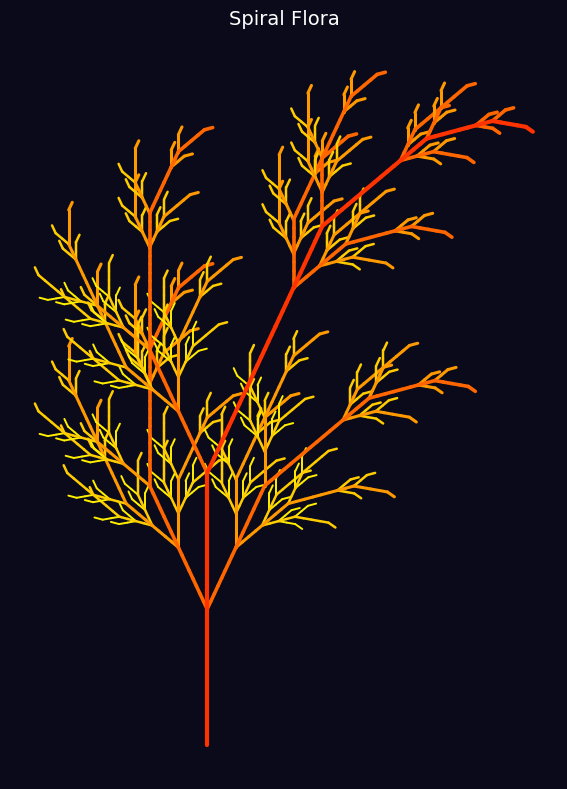

In [10]:
# --- Sample Output 1: Mission Log + Dread Mood ---
random.seed()
generate_full_output(
    "SAMPLE 1 — DREAD",
    mission_grammar, space_chain,
    mood='dread', markov_words=50
)

### Sample 1 — Dread
Mission Grammar + Space Log chain. Dread mood biasing boosts words like "silence", "void", and "cold" in the Markov output, pushing the field notes toward isolation and unease. Biome is auto-detected from keywords in the combined text.

  SAMPLE 2 — WONDER
  Detected Biome: BIOLUMINESCENT

[MISSION LOG]
No stars were visible — only the glow of distant nebulae. Jagged spires of obsidian rose from cracked earth. Clusters of bioluminescent fungi pulsed in slow waves. The wind carried a scent like burnt sugar and iron.

[FIELD NOTES]
alive and it was older than the star it orbited. We collected samples but none of us believed they would survive the journey home. This world did not want to be understood. It wanted to be understood. It wanted to be understood. It wanted to be experienced.



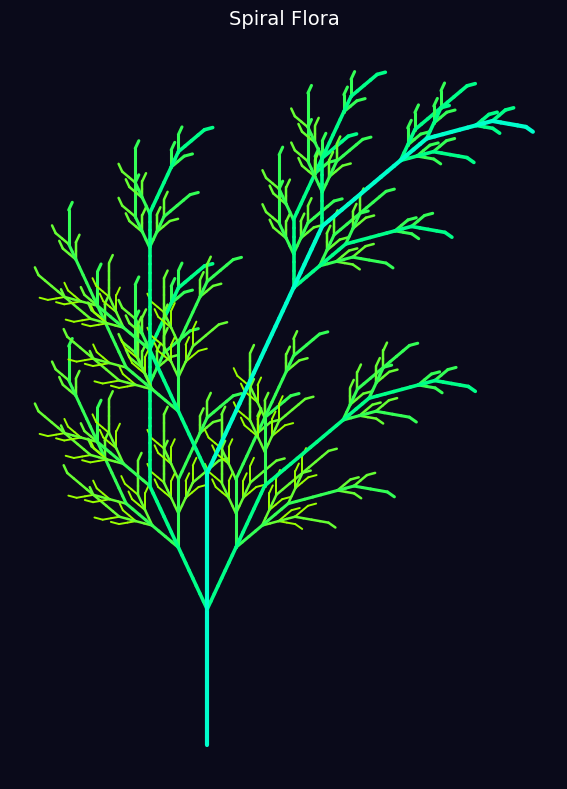

In [11]:
# --- Sample Output 2: Planet Description + Wonder Mood ---
random.seed()
generate_full_output(
    "SAMPLE 2 — WONDER",
    planet_grammar, alien_chain,
    mood='wonder', markov_words=50
)

### Sample 2 — Wonder
Planet Grammar + Alien World chain. Wonder mood biasing boosts words like "light", "crystal", and "alive". The Planet Grammar builds a sky/terrain/flora/atmosphere structure while the Markov chain adds sensory texture from the alien survey corpus.

  SAMPLE 3 — TENSION
  Detected Biome: VOLCANIC

[MISSION LOG]
Officer Okafor reporting from orbit above Vantablack Hollow — a barren moon scarred by ancient impact craters. Hidden beneath the surface we found a device emitting zero-point radiation — it responded to human bioelectric fields. No casualties yet. Proceeding to secondary objective.

[FIELD NOTES]
silence because words felt wrong in this place. Every sound we made was absorbed and returned as something different. A whisper became a chord. A footstep became a chord. A footstep became a drum. The planet was listening to us and we could feel it thinking. Dr. Tanaka knelt beside



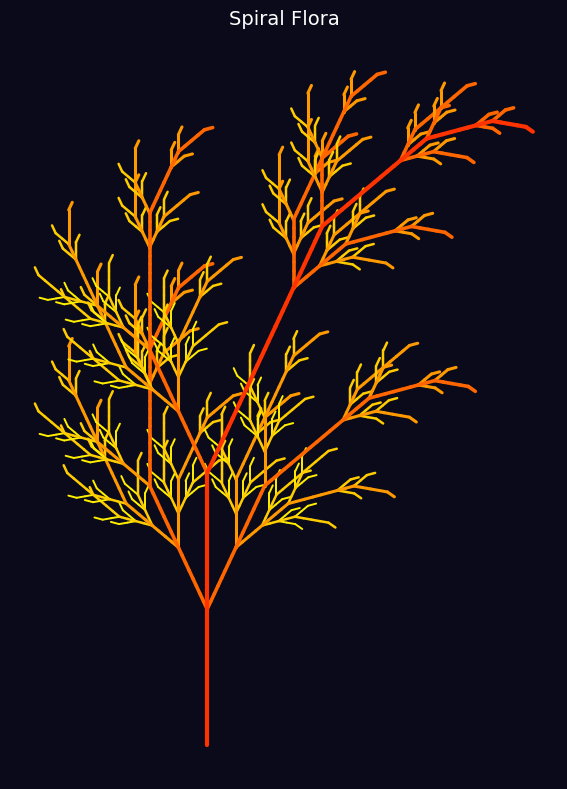

In [12]:
# --- Sample Output 3: Mission Log + Tension Mood ---
random.seed()
generate_full_output(
    "SAMPLE 3 — TENSION",
    mission_grammar, alien_chain,
    mood='tension', markov_words=50
)

### Sample 3 — Tension
Mission Grammar + Alien World chain. Tension mood biasing boosts words like "signal", "static", and "wrong". This cross-pairs mission log structure with alien surface texture, creating a first-contact scenario feel.

  SAMPLE 4 — BASELINE
  Detected Biome: FROZEN

[MISSION LOG]
The aurora above pulsed in rhythms like breathing. Frozen rivers carved deep canyons through basalt plains. Towering fronds of translucent coral swayed without wind. Gravity felt lighter here. Each step was a small leap.

[FIELD NOTES]
silence between stars where nothing moved and nothing breathed. Instruments hummed in the dark as the crew slept in frozen suspension. The hull groaned under the weight of empty space pressing in from all sides. Captain Voss stared at the viewport like the universe rearranging itself around them.



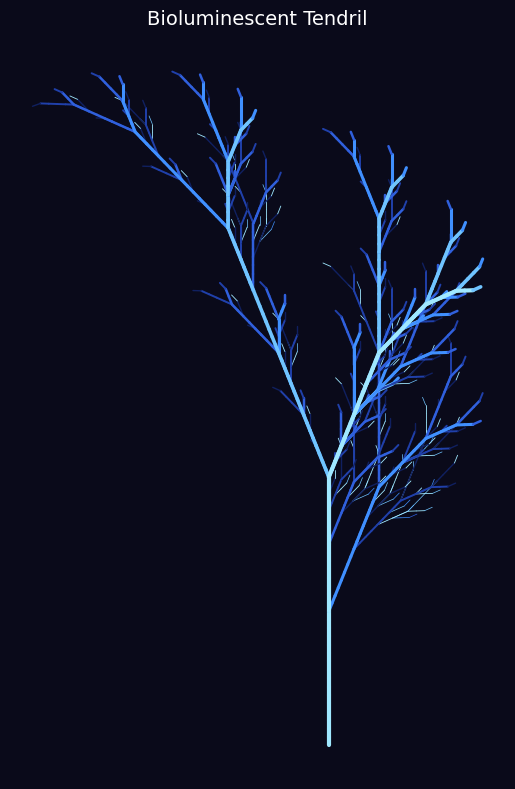

In [13]:
# --- Sample Output 4: Planet Description + No Mood (baseline) ---
random.seed()
generate_full_output(
    "SAMPLE 4 — BASELINE",
    planet_grammar, space_chain,
    mood=None, markov_words=50
)

### Sample 4 — Baseline
Planet Grammar + Space Log chain. No mood biasing applied — pure temperature-based Markov sampling at 0.8. This shows the system's default behavior without any emotional steering.

  SAMPLE 5 — WONDER (ALIEN WORLD)
  Detected Biome: CRYSTAL

[MISSION LOG]
Officer Tanaka recording from the surface of Lithara Prime — a rogue planet drifting between star systems. We made visual contact with a swarm of luminous spores emitting patterns that resemble language. All systems nominal. But something feels wrong.

[FIELD NOTES]
The surface stretched out in every direction like a wound exposed to starlight. Crystalline formations rose from the ground catching light and splitting it into colors that had no name. The soil was warm to the touch and pulsed faintly beneath our boots. We walked through fields of glass flowers



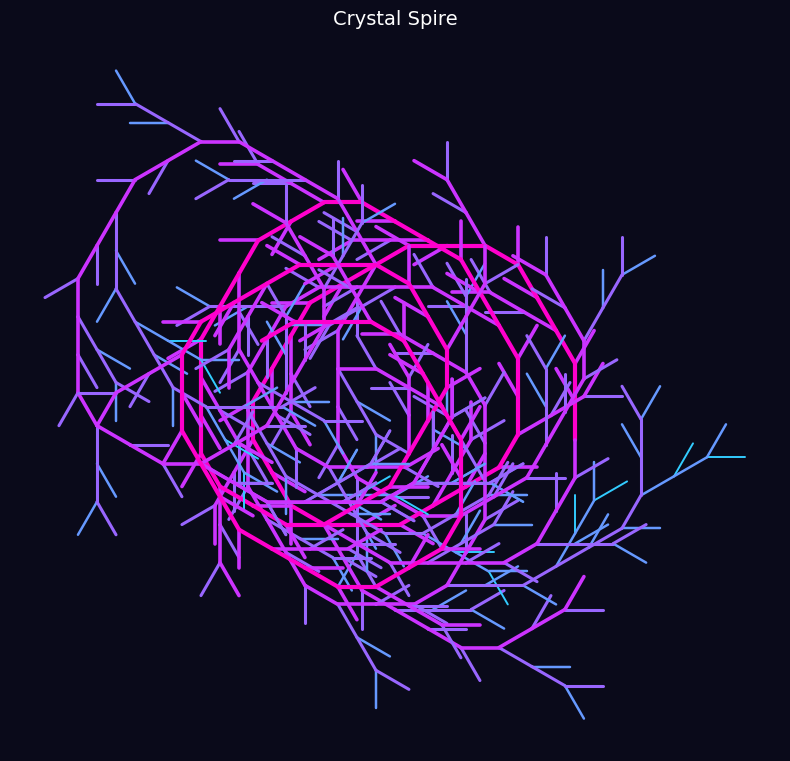

In [14]:
# --- Sample Output 5: Mission Log + Wonder + Alien Chain ---
random.seed()
generate_full_output(
    "SAMPLE 5 — WONDER (ALIEN WORLD)",
    mission_grammar, alien_chain,
    mood='wonder', markov_words=50
)

### Sample 5 — Wonder (Alien World)
Mission Grammar + Alien World chain. Same wonder mood as Sample 2 but with a different grammar and chain combo, demonstrating how swapping inputs changes the character of the output while keeping the same emotional tone.

## Analysis: Chain Statistics & Transition Tables

### Analysis: Chain Statistics & Transition Tables
This section prints statistics for both Markov chains (unique states, total transitions, average transitions per state) and a sample of each chain's transition table showing how states map to candidate next words. It also summarizes the grammar structure (non-terminal symbols and total productions) and displays the biome detection map showing which keywords trigger each L-System ruleset and color palette.

In [19]:
# --- Chain Analysis ---

print("=" * 60)
print("  MARKOV CHAIN ANALYSIS")
print("=" * 60)

print("\n--- Space Log Chain ---")
analyze_chain(space_chain)
print_transition_table(space_chain)

print("\n--- Alien World Chain ---")
analyze_chain(alien_chain)
print_transition_table(alien_chain)

# --- Grammar Coverage ---
print("\n" + "=" * 60)
print("  GRAMMAR ANALYSIS")
print("=" * 60)

for name, grammar in [("Mission Grammar", mission_grammar), ("Planet Grammar", planet_grammar)]:
    non_terminals = [k for k in grammar.keys()]
    terminals = 0
    productions = 0
    for key, rules in grammar.items():
        for rule in rules:
            productions += 1
            if isinstance(rule, str) and rule not in grammar:
                terminals += 1
    print(f"\n--- {name} ---")
    print(f"Non-terminal symbols: {len(non_terminals)}")
    print(f"Categories: {', '.join(non_terminals)}")
    print(f"Total productions: {productions}")

# --- Biome Detection Summary ---
print("\n" + "=" * 60)
print("  BIOME DETECTION MAP")
print("=" * 60)
for biome, config in BIOME_MAP.items():
    print(f"\n  {biome.upper()}")
    print(f"    Keywords: {', '.join(config['keywords'])}")
    print(f"    L-System: {config['ruleset']['name']}")
    print(f"    Palette:  {config['palette']}")

  MARKOV CHAIN ANALYSIS

--- Space Log Chain ---
Unique states: 176
Total transitions: 185
Avg transitions per state: 1.05

State -> Possible Next Words
  ('The', 'ship') -> {'drifted': 1, 'was': 1, 'turned': 1}
  ('ship', 'drifted') -> {'through': 1}
  ('drifted', 'through') -> {'the': 1}
  ('through', 'the') -> {'silence': 1}
  ('the', 'silence') -> {'between': 1}
  ('silence', 'between') -> {'stars': 1}
  ('between', 'stars') -> {'where': 1}
  ('stars', 'where') -> {'nothing': 1}

--- Alien World Chain ---
Unique states: 203
Total transitions: 205
Avg transitions per state: 1.01

State -> Possible Next Words
  ('The', 'surface') -> {'stretched': 1}
  ('surface', 'stretched') -> {'out': 1}
  ('stretched', 'out') -> {'in': 1}
  ('out', 'in') -> {'every': 1}
  ('in', 'every') -> {'direction': 1}
  ('every', 'direction') -> {'like': 1}
  ('direction', 'like') -> {'a': 1}
  ('like', 'a') -> {'wound': 1}

  GRAMMAR ANALYSIS

--- Mission Grammar ---
Non-terminal symbols: 17
Categories: S, 

## Interactive Mode

### Interactive Mode
Run this cell to customize generation at runtime. Choose a mood protocol (dread, wonder, tension), a grammar ruleset (mission or planet), and a Markov chain (space or alien). Press Enter on mood for a random selection. The system detects a biome from the generated text and draws a matching L-System visual.

=== HYBRID SCI-FI GENERATOR ===
Moods: dread, wonder, tension (or press Enter for random)
Grammars: mission, planet
Chains: space, alien

>> Mood: mission
Unknown mood 'mission', defaulting to random.
>> Grammar (mission/planet): planet
>> Chain (space/alien): Space

  INTERACTIVE TRANSMISSION
  Detected Biome: FROZEN

[MISSION LOG]
Three moons hung low, casting overlapping shadows. Rolling dunes of metallic sand stretched to the horizon. Towering fronds of translucent coral swayed without wind. A faint hum vibrated through the air, just below hearing.

[FIELD NOTES]
salvation or something far worse. The ship was old and the taste of recycled air. Voss ordered a course change toward the signal knowing it could be salvation or something far worse. The ship drifted through the silence between stars where nothing moved and nothing breathed. Instruments hummed in the



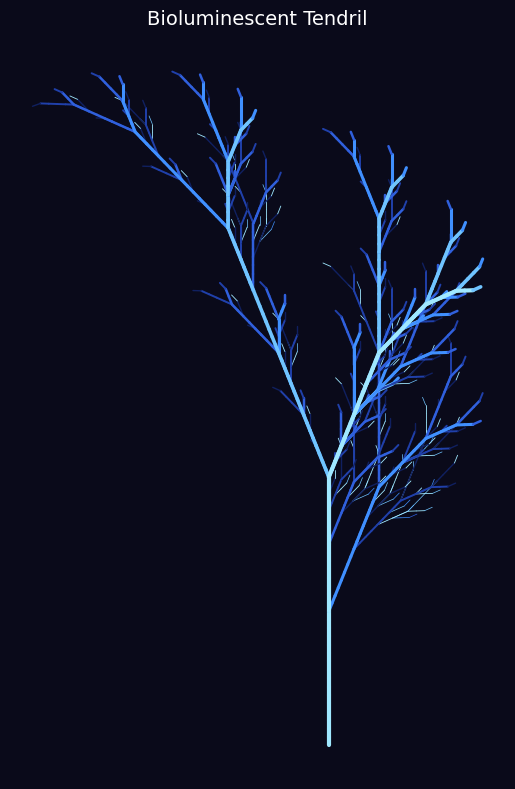

In [17]:
# --- INTERACTIVE GENERATOR ---
print("=== HYBRID SCI-FI GENERATOR ===")
print("Moods: dread, wonder, tension (or press Enter for random)")
print("Grammars: mission, planet")
print("Chains: space, alien")
print()

user_mood = input(">> Mood: ").strip().lower() or None
if user_mood and user_mood not in MOOD_WORDS:
    print(f"Unknown mood '{user_mood}', defaulting to random.")
    user_mood = None

user_grammar = input(">> Grammar (mission/planet): ").strip().lower()
grammar = planet_grammar if user_grammar == 'planet' else mission_grammar

user_chain = input(">> Chain (space/alien): ").strip().lower()
chain = alien_chain if user_chain == 'alien' else space_chain

print()
generate_full_output("INTERACTIVE TRANSMISSION", grammar, chain, mood=user_mood, markov_words=50)